# NIRS (model)

In [1]:
import utils as utils
import torch
import numpy as np
import pandas as pd
from icecream import ic
import matplotlib.pyplot as plt
import seaborn as sns

utils.seed_everything(42)

%matplotlib inline
sns.set_style('darkgrid')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Init and reading data

In [2]:
df = pd.read_csv('data/merged_data_processed.csv')
unreviewed_products_df = pd.read_csv('data/unreviewed_products_processed.csv')
products_df = pd.read_csv('data/products_sampled_processed.csv')
reviews_df = pd.read_csv('data/reviews_sampled_processed.csv')

print(products_df.shape, reviews_df.shape)

(233469, 47) (661471, 8)


In [3]:
# drop duplicates
reviews_df.drop_duplicates(subset=['reviewerID', 'asin', 'reviewText', 'summary'], inplace=True)

In [4]:
# join products and reviews datasets
df = reviews_df.merge(products_df, on='asin', how='inner')

unreviewed_products_df = products_df[~products_df['asin'].isin(reviews_df['asin'])]

In [5]:
print(f'Shape of df: {df.shape}')
print(f'Shape of unreviewed_products_df: {unreviewed_products_df.shape}')
print(f'Shape of products_df: {products_df.shape}')
print(f'Shape of reviews_df: {reviews_df.shape}')

Shape of df: (661471, 54)
Shape of unreviewed_products_df: (209585, 47)
Shape of products_df: (233469, 47)
Shape of reviews_df: (661471, 8)


## Other data preparation for the model

### User and product id mapping

In [6]:
user_ids = df['reviewerID'].values
product_ids = df['asin'].values

user_id_map = {uid: idx for idx, uid in enumerate(set(user_ids))}
product_id_map = {pid: idx for idx, pid in enumerate(set(product_ids))}

# Map user and item IDs to indices
df['user_index'] = df['reviewerID'].map(user_id_map)
df['item_index'] = df['asin'].map(product_id_map)

### Text Embeddings (with Word2Vec or whatever)

In [7]:
from gensim.models import Word2Vec

# Create embeddings using Word2Vec
def create_word2vec_embeddings(texts, embedding_dim):
  # Tokenize the texts
  tokenized_texts = [text.split() for text in texts]
  
  # Train Word2Vec model
  model = Word2Vec(tokenized_texts, vector_size=embedding_dim, window=5, min_count=1, workers=4)
  
  # Get the embeddings for each text
  embeddings = []
  for text in tokenized_texts:
      embedding = np.mean([model.wv[word] for word in text if word in model.wv], axis=0)
      embeddings.append(embedding)
  
  return np.array(embeddings)

In [8]:
df_reviewed_products = products_df[products_df['asin'].isin(df['asin'].unique())].drop_duplicates(subset=['asin'])
df_reviewed_products['brand'] = df_reviewed_products['brand'].astype(str)
df_reviewed_products['title'] = df_reviewed_products['title'].astype(str)
df_reviewed_products['description'] = df_reviewed_products['description'].astype(str)

df_reviewed_products.reset_index(drop=True, inplace=True)

In [9]:
# Create embeddings for textual data
text_embedding_dims = 200
reviewTexts_embs = torch.tensor(create_word2vec_embeddings(reviews_df['reviewText'].astype(str), embedding_dim=text_embedding_dims))
summary_embs = torch.tensor(create_word2vec_embeddings(reviews_df['summary'].astype(str), embedding_dim=text_embedding_dims))
title_embs = torch.tensor(create_word2vec_embeddings(products_df['title'].astype(str), embedding_dim=text_embedding_dims))
description_embs = torch.tensor(create_word2vec_embeddings(products_df['description'].astype(str), embedding_dim=text_embedding_dims))
feature_embs = torch.tensor(create_word2vec_embeddings(products_df['feature'].astype(str), embedding_dim=text_embedding_dims))
brand_embs = torch.tensor(create_word2vec_embeddings(products_df['brand'].astype(str), embedding_dim=text_embedding_dims))

#load the embeddings  
# reviewTexts_embs = torch.load('data/embeds/review_embeddings.pt')
# summary_embs = torch.load('data/embeds/summary_embeddings.pt')
# description_embs = torch.load('data/embeds/description_embeddings.pt')
# title_embs = torch.load('data/embeds/title_embeddings.pt')
# feature_embs = torch.load('data/embeds/feature_embeddings.pt')
# brand_embs = torch.load('data/embeds/brand_embeddings.pt')

print(reviewTexts_embs.shape, summary_embs.shape, title_embs.shape, description_embs.shape, feature_embs.shape, brand_embs.shape)

torch.Size([661471, 200]) torch.Size([661471, 200]) torch.Size([233469, 200]) torch.Size([233469, 200]) torch.Size([233469, 200]) torch.Size([233469, 200])


In [10]:
# review (user) embeddings by taking the mean of the review-related embeddings
reviews_text_embs = torch.mean(torch.stack([reviewTexts_embs, summary_embs]), dim=0)

# item embeddings by taking the mean of the item-related embeddings
products_text_embs = torch.mean(torch.stack([title_embs, description_embs, feature_embs, brand_embs]), dim=0)

In [11]:
user_embeddings_map = {}
for i, row in reviews_df.iterrows():
    user_id = row['reviewerID']   
    if user_id not in user_embeddings_map:
        user_embeddings_map[user_id] = [reviews_text_embs[i]]
    else:
        user_embeddings_map[user_id].append(reviews_text_embs[i])

for user_id, emb in user_embeddings_map.items():
    user_tensors = user_embeddings_map[user_id]
    user_embeddings_map[user_id] = torch.mean(torch.stack(user_tensors), dim=0)
    
    
df['user_embs'] = df['reviewerID'].map(user_embeddings_map)

In [12]:
all_product_embeddings = {}
for i, row in df_reviewed_products.iterrows():
    product_id = row['asin']
    all_product_embeddings[product_id] = products_text_embs[i]


reviewed_products_embeddings_map = {}
for i, row in df_reviewed_products.iterrows():
    product_id = row['asin']
    reviewed_products_embeddings_map[product_id] = all_product_embeddings[product_id]
    
df['product_embs'] = df['asin'].map(reviewed_products_embeddings_map)

## Model

### DataLoaders for the Pytorch-based model

In [13]:
def train_test_split_colab(df, test_size=0.2):
    """ 
    Split the dataframe into training and test sets,
    by taking a percentage of the review from each user     
    """
    train_set, test_set = [], []

    for _, group in df.groupby('reviewerID'):
        n = group.shape[0]
        test_n = int(n * test_size)
        test_indices = np.random.choice(group.index, size=test_n, replace=False)
        test_set.append(group.loc[test_indices])
        train_set.append(group.drop(test_indices))
        
    train_set = pd.concat(train_set)
    test_set = pd.concat(test_set)
    
    return train_set, test_set

In [14]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader 
import numpy as np

# class for the dataset
class AmazonReviewDataset(Dataset):
    def __init__(self, user_ids, product_ids, ratings, users_text_data, products_text_data):
        self.user_ids = user_ids
        self.product_ids = product_ids
        self.ratings = ratings
        self.users_text_data = users_text_data
        self.products_text_data = products_text_data
        
    def __len__(self):
        return len(self.user_ids)

    def __getitem__(self, index):
        user_id = self.user_ids[index]
        item_id = self.product_ids[index]
        rating = self.ratings[index]
        users_text_data = self.users_text_data[index]
        products_text_data = self.products_text_data[index]
        
        return user_id, item_id, rating, users_text_data, products_text_data

# Split the data into train and test sets
# train_data, val_data = train_test_split_colab(df, test_size=0.2)
train_data, val_data = train_test_split_colab(df, test_size=0.2)


# Create train and test datasets
train_dataset = AmazonReviewDataset(
    train_data['user_index'].values,
    train_data['item_index'].values,
    train_data['overall'].values,
    train_data['user_embs'].values,
    train_data['product_embs'].values

)

test_dataset = AmazonReviewDataset(
    val_data['user_index'].values,
    val_data['item_index'].values,
    val_data['overall'].values,
    val_data['user_embs'].values,
    train_data['product_embs'].values
)

### Quick model test with SVD from scikit-surprise

Quick performance check of SVD by using scikit-surprise:

In [15]:
from surprise import BaselineOnly, Dataset, SVD, Reader, accuracy, Trainset
from surprise.model_selection import cross_validate, train_test_split, KFold

# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data_test = Dataset.load_from_df(df[["reviewerID", "asin", "overall"]], reader)

# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data_test, test_size=0.25)

# define a cross-validation iterator
kf = KFold(n_splits=5)

algo = SVD()

for trainset, testset in kf.split(data_test):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)

RMSE: 0.9300
RMSE: 0.9356
RMSE: 0.9327
RMSE: 0.9313
RMSE: 0.9323


In [16]:
user_id = 'A1HBTW5M7ZZ9PT'
test_user = reviews_df[reviews_df['reviewerID'] == user_id]
item_id = 'B00006IEI7'

In [17]:
# get a prediction for specific users and items.
pred = algo.predict(user_id, item_id, r_ui=5, verbose=True)

user: A1HBTW5M7ZZ9PT item: B00006IEI7 r_ui = 5.00   est = 4.43   {'was_impossible': False}


### Neural Collaborative Filtering

In [18]:
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from time import time
from evaluate import evaluate_model
from Dataset import Dataset

class NeuMF(nn.Module):class NeuMF(nn.Module):
    def __init__(self, num_users, num_items, mf_dim, layers, reg_layers, reg_mf):
        super(NeuMF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.mf_dim = mf_dim
        self.layers = layers
        self.num_layers = len(layers)
        self.reg_layers = reg_layers
        self.reg_mf = reg_mf
        
        self.mf_embedding_user = nn.Embedding(num_users, mf_dim)
        self.mf_embedding_item = nn.Embedding(num_items, mf_dim)
        
        self.mlp_embedding_user = nn.Embedding(num_users, layers[0]//2)
        self.mlp_embedding_item = nn.Embedding(num_items, layers[0]//2)
        
        self.mlp_layers = nn.ModuleList()
        for i in range(1, self.num_layers):
            self.mlp_layers.append(nn.Linear(layers[i-1], layers[i]))
        
        self.prediction_layer = nn.Linear(layers[-1] + mf_dim, 1)
        
    def forward(self, user_input, item_input, user_text_embeddings, item_text_embeddings):
        mf_user_latent = self.mf_embedding_user(user_input)
        mf_item_latent = self.mf_embedding_item(item_input)
        mf_vector = mf_user_latent * mf_item_latent
        
        mlp_user_latent = self.mlp_embedding_user(user_input)
        mlp_item_latent = self.mlp_embedding_item(item_input)
        mlp_vector = torch.cat([mlp_user_latent, mlp_item_latent, user_text_embeddings, item_text_embeddings], dim=-1)
        
        for i in range(1, self.num_layers):
            mlp_vector = self.mlp_layers[i-1](mlp_vector)
            mlp_vector = nn.ReLU()(mlp_vector)
        
        predict_vector = torch.cat([mf_vector, mlp_vector], dim=-1)
        prediction = self.prediction_layer(predict_vector)
        return prediction.view(-1)
    def __init__(self, num_users, num_items, mf_dim, layers, reg_layers, reg_mf):
        super(NeuMF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.mf_dim = mf_dim
        self.layers = layers
        self.num_layers = len(layers)
        self.reg_layers = reg_layers
        self.reg_mf = reg_mf
        
        self.mf_embedding_user = nn.Embedding(num_users, mf_dim)
        self.mf_embedding_item = nn.Embedding(num_items, mf_dim)
        
        self.mlp_embedding_user = nn.Embedding(num_users, layers[0]//2)
        self.mlp_embedding_item = nn.Embedding(num_items, layers[0]//2)
        
        self.mlp_layers = nn.ModuleList()
        for i in range(1, self.num_layers):
            self.mlp_layers.append(nn.Linear(layers[i-1], layers[i]))
        
        self.prediction_layer = nn.Linear(layers[-1] + mf_dim, 1)
        
    def forward(self, user_input, item_input, user_text_embeddings, item_text_embeddings):
        mf_user_latent = self.mf_embedding_user(user_input)
        mf_item_latent = self.mf_embedding_item(item_input)
        mf_vector = mf_user_latent * mf_item_latent
        
        mlp_user_latent = self.mlp_embedding_user(user_input)
        mlp_item_latent = self.mlp_embedding_item(item_input)
        mlp_vector = torch.cat([mlp_user_latent, mlp_item_latent, user_text_embeddings, item_text_embeddings], dim=-1)
        
        for i in range(1, self.num_layers):
            mlp_vector = self.mlp_layers[i-1](mlp_vector)
            mlp_vector = nn.ReLU()(mlp_vector)
        
        predict_vector = torch.cat([mf_vector, mlp_vector], dim=-1)
        prediction = self.prediction_layer(predict_vector)
        return prediction.view(-1)
    
def get_train_instances(train, num_negatives):
    user_input, item_input, labels = [], [], []
    num_users = train.shape[0]
    for (u, i) in train.keys():
        # positive instance
        user_input.append(u)
        item_input.append(i)
        labels.append(1)
        # negative instances
        for _ in range(num_negatives):
            j = np.random.randint(num_items)
            while train.has_key((u, j)):
                j = np.random.randint(num_items)
            user_input.append(u)
            item_input.append(j)
            labels.append(0)
    return user_input, item_input, labels

if __name__ == '__main__':
    args = parse_args()
    num_epochs = args.epochs
    batch_size = args.batch_size
    mf_dim = args.num_factors
    layers = eval(args.layers)
    reg_mf = args.reg_mf
    reg_layers = eval(args.reg_layers)
    num_negatives = args.num_neg
    learning_rate = args.lr
    learner = args.learner
    verbose = args.verbose
    
    topK = 10
    print("NeuMF arguments: %s " %(args))
    model_out_file = 'Pretrain/%s_NeuMF_%d_%s_%d.pt' %(args.dataset, mf_dim, args.layers, time())
    
    # Loading data
    t1 = time()
    dataset = Dataset(args.path + args.dataset)
    train, testRatings, testNegatives = dataset.trainMatrix, dataset.testRatings, dataset.testNegatives
    num_users, num_items = train.shape
    print("Load data done [%.1f s]. #user=%d, #item=%d, #train=%d, #test=%d" 
          %(time()-t1, num_users, num_items, train.nnz, len(testRatings)))
    
    # Build model
    model = NeuMF(num_users, num_items, mf_dim, layers, reg_layers, reg_mf)
    if learner.lower() == "adagrad": 
        optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)
    elif learner.lower() == "rmsprop":
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    elif learner.lower() == "adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    else:
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    criterion = nn.BCEWithLogitsLoss()
    
    # Check Init performance
    (hits, ndcgs) = evaluate_model(model, testRatings, testNegatives, topK)
    hr, ndcg = np.array(hits).mean(), np.array(ndcgs).mean()
    print('Init: HR = %.4f, NDCG = %.4f' % (hr, ndcg))
    best_hr, best_ndcg, best_iter = hr, ndcg, -1
    if args.out > 0:
        torch.save(model.state_dict(), model_out_file)
    
    # Training model
    for epoch in range(num_epochs):
        t1 = time()
        # Generate training instances
        user_input, item_input, labels = get_train_instances(train, num_negatives)
        
        # Training
        model.train()
        for i in range(0, len(user_input), batch_size):
            batch_user_input = torch.LongTensor(user_input[i:i+batch_size])
            batch_item_input = torch.LongTensor(item_input[i:i+batch_size])
            batch_user_text_embeddings = torch.FloatTensor(dataset.user_text_embeddings[user_input[i:i+batch_size]])
            batch_item_text_embeddings = torch.FloatTensor(dataset.item_text_embeddings[item_input[i:i+batch_size]])
            batch_labels = torch.FloatTensor(labels[i:i+batch_size])
            optimizer.zero_grad()
            predictions = model(batch_user_input, batch_item_input, batch_user_text_embeddings, batch_item_text_embeddings)
            loss = criterion(predictions, batch_labels)
            loss.backward()
            optimizer.step()
        t2 = time()
        
        # Evaluation
        if epoch % verbose == 0:
            model.eval()
            (hits, ndcgs) = evaluate_model(model, testRatings, testNegatives, topK)
            hr, ndcg = np.array(hits).mean(), np.array(ndcgs).mean()
            print('Iteration %d [%.1f s]: HR = %.4f, NDCG = %.4f, loss = %.4f [%.1f s]' 
                  % (epoch, t2-t1, hr, ndcg, loss.item(), time()-t2))
            if hr > best_hr:
                best_hr, best_ndcg, best_iter = hr, ndcg, epoch
                if args.out > 0:
                    torch.save(model.state_dict(), model_out_file)
    
    print("End. Best Iteration %d:  HR = %.4f, NDCG = %.4f. " %(best_iter, best_hr, best_ndcg))
    if args.out > 0:
        print("The best NeuMF model is saved to %s" %(model_out_file))

SyntaxError: invalid syntax (3930242501.py, line 10)

In [19]:
from torch import nn

class NeuMF(nn.Module):
    def __init__(self, num_users, num_items, mf_dim, layers, reg_layers, reg_mf):
        super(NeuMF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.mf_dim = mf_dim
        self.layers = layers
        self.num_layers = len(layers)
        self.reg_layers = reg_layers
        self.reg_mf = reg_mf
        
        self.mf_embedding_user = nn.Embedding(num_users, mf_dim)
        self.mf_embedding_item = nn.Embedding(num_items, mf_dim)
        
        self.mlp_embedding_user = nn.Embedding(num_users, layers[0]//2)
        self.mlp_embedding_item = nn.Embedding(num_items, layers[0]//2)
        
        self.mlp_layers = nn.ModuleList()
        for i in range(1, self.num_layers):
            self.mlp_layers.append(nn.Linear(layers[i-1], layers[i]))
        
        self.prediction_layer = nn.Linear(layers[-1] + mf_dim, 1)
        
    def forward(self, user_input, item_input, user_text_embeddings, item_text_embeddings):
        mf_user_latent = self.mf_embedding_user(user_input)
        mf_item_latent = self.mf_embedding_item(item_input)
        mf_vector = mf_user_latent * mf_item_latent
        
        mlp_user_latent = self.mlp_embedding_user(user_input)
        mlp_item_latent = self.mlp_embedding_item(item_input)
        mlp_vector = torch.cat([mlp_user_latent, mlp_item_latent, user_text_embeddings, item_text_embeddings], dim=-1)
        
        for i in range(1, self.num_layers):
            mlp_vector = self.mlp_layers[i-1](mlp_vector)
            mlp_vector = nn.ReLU()(mlp_vector)
        
        predict_vector = torch.cat([mf_vector, mlp_vector], dim=-1)
        prediction = self.prediction_layer(predict_vector)
        return prediction.view(-1)

class NCF(nn.Module):
  def __init__(self, n_users, n_items, emb_dim, text_user_dim, text_item_dim, dropout_rate=0.2) -> None:
    super(NCF, self).__init__()
    self.min_rating = 1
    self.max_rating = 5
    self.n_users = n_users
    self.n_items = n_items
    self.emb_dim = emb_dim
    
    # GMF embeddings
    self.user_embedding_gmf = nn.Embedding(n_users, emb_dim)
    self.item_embedding_gmf = nn.Embedding(n_items, emb_dim)
    
    # MLP embeddings
    self.user_embedding_mlp = nn.Embedding(n_users, 2048 // 2)
    self.item_embedding_mlp = nn.Embedding(n_items, 2048 // 2)
    
    # text embeddings
    self.user_text_layer = nn.Linear(text_user_dim, text_user_dim)
    self.item_text_layer = nn.Linear(text_item_dim, text_item_dim)
    
    # MLP layers
    self.fc_layers = nn.Sequential(
      nn.Linear(800, 1024),
      nn.ReLU(),
      nn.Dropout(p=dropout_rate),
      nn.BatchNorm1d(1024),
      
      nn.Linear(1024, 512),
      nn.ReLU(),
      nn.Dropout(p=dropout_rate),
      nn.BatchNorm1d(512),
      
      nn.Linear(512, 256),
      nn.ReLU(),
      nn.Dropout(p=dropout_rate),
      nn.BatchNorm1d(256),
      
      nn.Linear(256, 128),
      nn.ReLU(),
      nn.Dropout(p=dropout_rate),
      nn.BatchNorm1d(128),
      
      nn.Linear(128, 64),
      nn.ReLU()
    )
    
    # Output layertorch.mul(user_gmf, item_gmf)
    self.output_layer = nn.Linear(emb_dim + 64, 1)
    
    # Initialize weights
    self._init_embs_weight_()
        
  def _init_embs_weight_(self):
    nn.init.normal_(self.user_embedding_gmf.weight, std=0.01)
    nn.init.normal_(self.item_embedding_gmf.weight, std=0.01)
    nn.init.normal_(self.user_embedding_mlp.weight, std=0.01)
    nn.init.normal_(self.item_embedding_mlp.weight, std=0.01)
    
  def forward(self, user_ids, item_ids, user_texts, item_texts):
    # GMF part
    user_gmf = self.user_embedding_gmf(user_ids)
    item_gmf = self.item_embedding_gmf(item_ids)
    gmf_output = user_gmf * item_gmf
    
    # MLP part
    user_mlp = self.user_embedding_mlp(user_ids)
    item_mlp = self.item_embedding_mlp(item_ids)
    user_text_mlp = self.user_text_layer(user_texts)
    item_text_mlp = self.item_text_layer(item_texts)
    mlp_input = torch.cat([user_mlp, item_mlp, user_text_mlp, item_text_mlp], dim=1)
    mlp_output = self.fc_layers(mlp_input)
    
    # Concatenate GMF and MLP output
    output = self.output_layer(torch.cat([gmf_output, mlp_output], dim=1))
    output = output * (self.max_rating - self.min_rating) + self.min_rating
    return output

#### Training and evaluating - related functions

In [20]:
# Train the NCF model
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm
from torch import nn

class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

def train_model(model: NCF, train_data: AmazonReviewDataset, val_data: AmazonReviewDataset, loss_func, optimizer, device, num_epochs):
    train_loss_history = []
    valid_loss_history = []
    precision_at_k_history = []
    
    model.to(device)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    for epoch in range(num_epochs):
        model.train()
        train_loss_sum = 0

        # For each batch
        for user_ids, item_ids, rating, u_text_embeds, p_text_embeds in tqdm(train_data, desc='Training...'):
            user_ids, item_ids, rating = user_ids.to(device), item_ids.to(device), rating.to(device)
            u_text_embeds, p_text_embeds = u_text_embeds.to(device), p_text_embeds.to(device)
            
            optimizer.zero_grad()
            outputs = model(user_ids, item_ids, u_text_embeds, p_text_embeds)
            loss = loss_func(outputs.squeeze(), rating.float())
            loss.backward()
            optimizer.step()
            
            train_loss_sum += loss.item()

        model.eval()
        scheduler.step()
        val_loss, _, _ = predict_and_evaluate(model, val_data, loss_func, device)
                
        # for both training and validation, the actual train loss
        # is the average loss over the entire dataset (the multiple batches)
        train_loss = np.sqrt(train_loss_sum / len(train_data))
        train_loss_history.append(train_loss)
        valid_loss_history.append(val_loss)
        
        # precision@k
        p_at_k = precision_at_k(model, val_data, 10)
        precision_at_k_history.append(p_at_k)
        
        print(f'Epoch {epoch+1}: train loss = {train_loss:.4f}, val loss = {val_loss:.4f}, HR@k = {p_at_k:.4f}')
    
    return train_loss_history, valid_loss_history
        
# Evaluate the NCF model
def predict_and_evaluate(model, data, loss_func, device):
    predictions = []
    true_ratings = []
    loss_sum = 0.0
    
    with torch.no_grad():
        for user_ids, item_ids, rating, u_text_embeds, p_text_embeds in tqdm(data, desc='Evaluating...'):
            user_ids = user_ids.to(device)
            item_ids = item_ids.to(device)
            u_text_embeds = u_text_embeds.to(device)
            p_text_embeds = p_text_embeds.to(device)
            
            outputs = model(user_ids, item_ids, u_text_embeds, p_text_embeds)
            predictions.extend(outputs.squeeze().tolist())
            true_ratings.extend(rating.tolist())
            
            loss_sum += loss_func(outputs.squeeze(), rating.float()).item()

    rmse = np.sqrt(loss_sum / len(data))
    mse = mean_squared_error(true_ratings, predictions)
    mae = mean_absolute_error(true_ratings, predictions)
    return rmse, mse, mae
  
def precision_at_k(model, test_dataset, k):
    model.eval()
    
    precision_sum = 0.0
    total_users = 0
    
    with torch.no_grad():
        for user_ids, item_ids, rating, u_text_embeds, p_text_embeds in test_dataset:
            # Get the predicted scores for all items
            user_ids = user_ids.to(device)
            item_ids = item_ids.to(device)
            u_text_embeds = u_text_embeds.to(device)
            p_text_embeds = p_text_embeds.to(device)
            
            scores = model(user_ids, item_ids, u_text_embeds, p_text_embeds)
            
            # Get the indices of the top K items
            _, indices = torch.topk(scores.squeeze(), k)
            
            # Check how many of the top K items are relevant
            relevant_count = 0
            for item in item_ids:
                if item in indices:
                    relevant_count += 1
            
            # Calculate Precision@K for the current user
            precision = relevant_count / k
            
            precision_sum += precision
            total_users += 1
    
    # Calculate average Precision@K across all users
    average_precision = precision_sum / total_users
    
    return average_precision

#### Model training

In [21]:
import torch.optim as optim
import torch.nn as nn

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False)

# Create the NCF model
num_users = len(user_id_map)
num_items = len(product_id_map)
emb_dim = 768
droput_rate_fc = 0
text_embedding_dims = [emb.shape[1] for emb in [reviews_text_embs, products_text_embs]]

model = NCF(
  num_users, num_items, emb_dim, 768, 768, droput_rate_fc).to(device)

# Define loss function and optimizer
loss_func = RMSELoss()
# criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Train the model
num_epochs = 10
print('Loss criterion: RMSE\n')
train_loss_history, val_loss_history = train_model(model, train_loader, test_loader, loss_func, optimizer, device, num_epochs)

Loss criterion: RMSE



Training...:   0%|          | 0/278 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (2048x200 and 768x768)

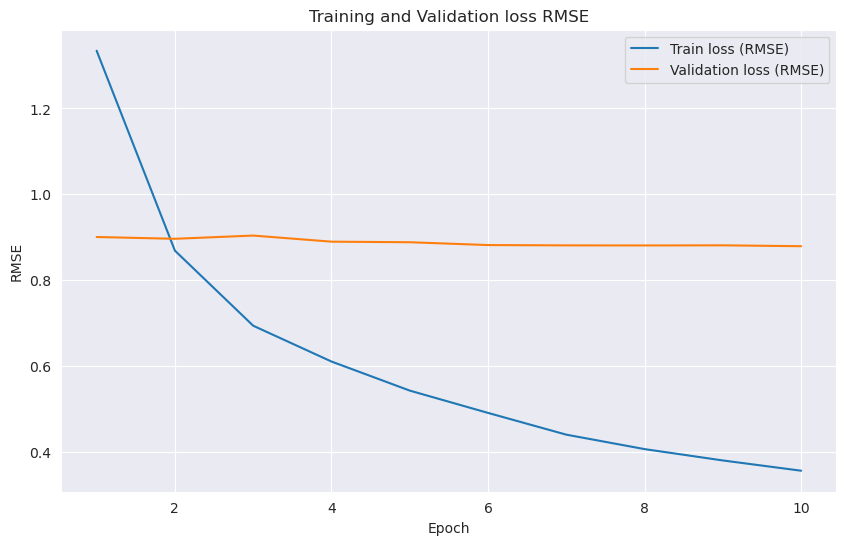

In [ ]:
def plot_accuracy(train_acc_history, val_acc_history, loss_name='RMSE'):
  df = pd.DataFrame({'Epoch': range(1, len(train_acc_history)+1),
             'Train Accuracy': train_acc_history, 
             'Validation Accuracy': val_acc_history})

  plt.figure(figsize=(10, 6))
  sns.lineplot(data=df, x='Epoch', y='Train Accuracy', label=f'Train loss ({loss_name})')
  sns.lineplot(data=df, x='Epoch', y='Validation Accuracy', label=f'Validation loss ({loss_name})')
  plt.xlabel('Epoch')
  plt.ylabel(loss_name)
  plt.title(f'Training and Validation loss {loss_name}')
  plt.legend()
  plt.show()
  
plot_accuracy(train_loss_history, val_loss_history, 'RMSE')

#### Model test with single predictions

In [ ]:
def predict_score(user_id, item_id, model, user_mapping, item_mapping, device):
    # Convert user ID and item ID to their corresponding indices
    user_index = user_mapping[user_id]
    item_index = item_mapping[item_id]

    # Convert indices to tensors
    user_tensor = torch.tensor([user_index], dtype=torch.long).to(device)
    item_tensor = torch.tensor([item_index], dtype=torch.long).to(device)

    # Get the predicted score from the model
    with torch.no_grad():
        model.eval()
        score = model(user_tensor, item_tensor).item()

    return score

print(f'Predicted rating for user {user_id} and item {item_id}: {predict_score(user_id, 'B0006HXE1E', model, user_mapping, product_mapping, device)}')
# print(f'Actual rating: {user_product_matrix.loc[user_id, item_id]}')

NameError: name 'user_mapping' is not defined

In [ ]:
unreviewed_products_df.head(2)